In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import math
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree
from sklearn.metrics import r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BA476/Data/NY-House-Dataset.csv')
#df

#Initial data cleaning and plots to understand our data

Maximum Price: 2147483647
Minimum Price: 2494
Average Price: 2356940.17100604
Percentiles:
0.25     499000.0
0.50     825000.0
0.75    1495000.0
Name: PRICE, dtype: float64
TYPE
Co-op for sale                1450
House for sale                1011
Condo for sale                 891
Multi-family home for sale     727
Townhouse for sale             299
Name: count, dtype: int64
Maximum Price: 195000000
Minimum Price: 49500
Average Price: 1974781.44243947
Percentile:
0.25     499000.0
0.50     845000.0
0.75    1500000.0
Name: PRICE, dtype: float64


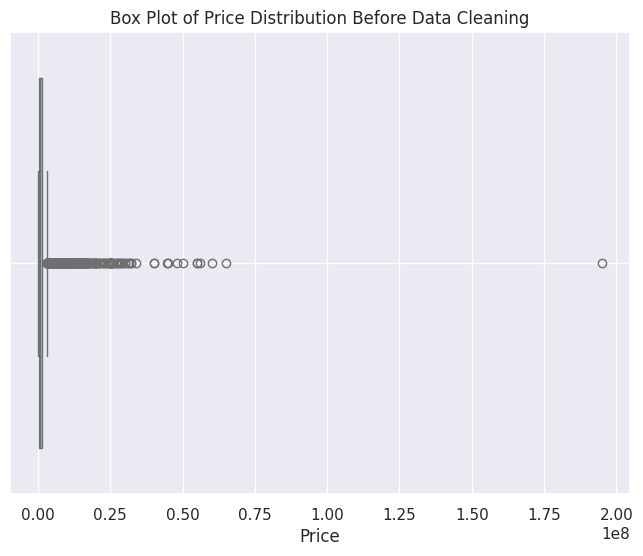

In [ ]:
# We remove these columns because they are not necessary
remove = ['LONG_NAME', 'ADDRESS', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2', 'STREET_NAME','LOCALITY','SUBLOCALITY']
df = df.drop(columns=remove)

# This will help us determine the outliers
max_price = np.max(df['PRICE']) # find the max price
min_price = np.min(df['PRICE']) # find the min price
avg_price = df['PRICE'].mean() # find the average price
quartiles = df['PRICE'].quantile([0.25, 0.5, 0.75]) # what percentile the price falls in
print("Maximum Price:", max_price) # print the max price
print("Minimum Price:", min_price) # print the min price
print("Average Price:", avg_price) # print the average price
print("Percentiles:")
print(quartiles) # print where each of the values fall

max_price_index = df['PRICE'].idxmax() #find the max price
df.drop(max_price_index, inplace=True) # remove the max price because it is an outlier

rm = ['Pending', 'Contingent', 'Land for sale', 'For sale', 'Foreclosure', 'Condop for sale', 'Coming Soon', 'Mobile house for sale']
values = [val not in rm for val in df['TYPE']] #true if not in the type column
df = df[values]
print(df['TYPE'].value_counts())
# see how this change affected the max, mean, and min
max_price = df['PRICE'].max()
min_price = df['PRICE'].min()
avg_price = df['PRICE'].mean()
quartiles = df['PRICE'].quantile([0.25, 0.5, 0.75])
print("Maximum Price:", max_price)
print("Minimum Price:", min_price)
print("Average Price:", avg_price)
print("Percentile:")
print(quartiles)


# plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['PRICE'], color='skyblue')
plt.title('Box Plot of Price Distribution Before Data Cleaning')
plt.xlabel('Price')
plt.grid(True)
plt.show()


Total number of rows: 4223
Maximum Price: 9995000
Minimum Price: 49500
Average Price: 1282474.3443049965
Quartile Values (25th, 50th, 75th percentile):
0.25     479700.0
0.50     799000.0
0.75    1395000.0
Name: PRICE, dtype: float64


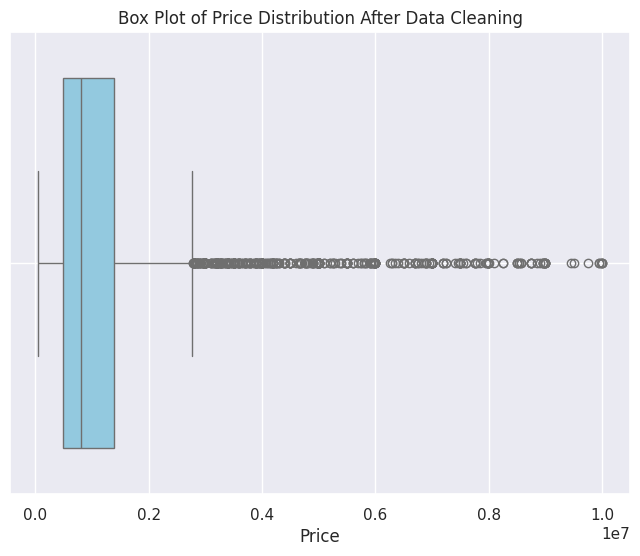

In [ ]:
# Removing properties over 10 million price
df = df[df['PRICE'] < 10000000]
print("Total number of rows:",len(df))
max_price = df['PRICE'].max()
# Minimum value of PRICE
min_price = df['PRICE'].min()
# Average value of PRICE
avg_price = df['PRICE'].mean()
# Percentiles
quartiles = df['PRICE'].quantile([0.25, 0.5, 0.75])
print("Maximum Price:", max_price)
print("Minimum Price:", min_price)
print("Average Price:", avg_price)
print("Quartile Values (25th, 50th, 75th percentile):")
print(quartiles)


plt.figure(figsize=(8, 6))
sns.boxplot(x=df['PRICE'], color='skyblue')
plt.title('Box Plot of Price Distribution After Data Cleaning')
plt.xlabel('Price')
plt.grid(True)
plt.show()

## Exploratory Analysis

#Dummy variables and feature engineering

In [ ]:
# for price percentile
# from most expensive to least and then divide into 10% intervals
deciles = [np.percentile(df['PRICE'], i) for i in range(10, 100, 10)]
intervals = []
for i in range(len(deciles)-1):
    interval = (deciles[i], deciles[i+1])
    intervals.append(interval)
for i, interval in enumerate(intervals):
    print(f"Interval {i+1}: {interval}")

Interval 1: (279000.0, 399000.0)
Interval 2: (399000.0, 555000.0)
Interval 3: (555000.0, 680000.0)
Interval 4: (680000.0, 799000.0)
Interval 5: (799000.0, 975000.0)
Interval 6: (975000.0, 1250000.0)
Interval 7: (1250000.0, 1688888.0)
Interval 8: (1688888.0, 2750000.0)


In [ ]:

# Turn PRICE into categorical variable for classification tree

intervals = [(0, 279000.0),
  (279000.0, 399000.0),
 (399000.0, 555000.0),
 (555000.0, 680000.0),
 (680000.0, 799000.0),
 (799000.0, 975000.0),
 (975000.0, 1250000.0),
 (1250000.0, 1688888.0),
 (1688888.0, 2750000.0),
             (2750000.0, 100000000.0)]

percentile_labels = [
    '0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%',
    '60-70%', '70-80%', '80-90%', '90-100%'
]

# Function that assigns properties to their respective percentile group
def assign_percentile(price):
    for i, (start, end) in enumerate(intervals):
        if start <= price < end:
            return percentile_labels[i]
    return '90-100%'

df['Price_Percentile'] = df['PRICE'].apply(assign_percentile) # assign each one to the proper percentile and create a new column


In [ ]:
# Creating dummy variables for TYPE
dummy_df = pd.get_dummies(df['TYPE']).astype(int)
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_df], axis=1)
# Drop the original 'TYPE' column if you don't need it anymore
df_with_dummies.drop('TYPE', axis=1, inplace=True)
df_with_dummies.rename(columns={'Co-op for sale': 'Co-op'}, inplace=True)
df_with_dummies.rename(columns={'Condo for sale': 'Condo'}, inplace=True)
df_with_dummies.rename(columns={'House for sale': 'House'}, inplace=True)
df_with_dummies.rename(columns={'Multi-family home for sale': 'Multi-family'}, inplace=True)
df_with_dummies.rename(columns={'Townhouse for sale': 'Townhouse'}, inplace=True)
df = df_with_dummies


# Getting Zipcode and Intializing Neighborhood
df['ZIPCODE'] = df['STATE'].str.extract(r'(\d{5}$)')
df['ZIPCODE'] = df['ZIPCODE'].astype(int)
df['NEIGHBORHOOD'] = pd.NA
df
# Dataset of NYC zipcodes to associated neighborhood
df1 = pd.read_csv('/content/drive/MyDrive/BA476/Data/NYC_Zips.csv')
df1.rename(columns={'ZIP Codes': 'ZIPCODE'}, inplace=True)
df1.rename(columns={'Neighborhood': 'NEIGHBORHOOD'}, inplace=True)
df1

# Merged dataset and added Null neighborhoods manually
merged_df = pd.merge(df, df1, on='ZIPCODE', suffixes=(''
, '_df1'), how='left')
# Replace NaN values in 'NEIGHBORHOOD' with values from df1
merged_df['NEIGHBORHOOD'] = merged_df['NEIGHBORHOOD_df1'].fillna(merged_df['NEIGHBORHOOD'])
# Drop the extra 'NEIGHBORHOOD_df1' column
merged_df.drop('NEIGHBORHOOD_df1', axis=1, inplace=True)
columns_to_remove = ['Borough']
merged_df = merged_df.drop(columns=columns_to_remove)
df = merged_df

# Manually adding neighborhoods that NYC_Zips did not have
df.loc[df['ZIPCODE'] == 11249, 'NEIGHBORHOOD'] = 'Bushwick and Williamsburg'
df.loc[df['ZIPCODE'] == 10069, 'NEIGHBORHOOD'] = 'Upper West Side'
df.loc[df['ZIPCODE'] == 11001, 'NEIGHBORHOOD'] = 'West Queens'
df.loc[df['ZIPCODE'] == 10282, 'NEIGHBORHOOD'] = 'Lower Manhattan'
df.loc[df['ZIPCODE'] == 11040, 'NEIGHBORHOOD'] = 'West Queens'
df.loc[df['ZIPCODE'] == 11109, 'NEIGHBORHOOD'] = 'Northwest Queens'

# Creating dummies for these neighborhoods
neighborhood_dummies = pd.get_dummies(df['NEIGHBORHOOD']).astype(int)
# Concatenate the original DataFrame with the dummy variables
df = pd.concat([df, neighborhood_dummies], axis=1)
# Drop the original 'NEIGHBORHOOD' column
#df.drop('NEIGHBORHOOD', axis=1, inplace=True)

df.head()

,BROKERTITLE,PRICE,BEDS,BATH,PROPERTYSQFT,STATE,FORMATTED_ADDRESS,LATITUDE,LONGITUDE,Price_Percentile,...,Southeast Queens,Southern Brooklyn,Southwest Brooklyn,Southwest Queens,Stapleton and St. George,Sunset Park,Upper East Side,Upper West Side,West Central Queens,West Queens
0,Brokered by Douglas Elliman -111 Fifth Ave,315000,2,2.0,1400.000000,"New York, NY 10022","Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483,10-20%,...,0,0,0,0,0,0,0,0,0,0
1,Brokered by Sowae Corp,260000,4,2.0,2015.000000,"Staten Island, NY 10312","620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109,0-10%,...,0,0,0,0,0,0,0,0,0,0
2,Brokered by COMPASS,69000,3,1.0,445.000000,"Manhattan, NY 10022","2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613,0-10%,...,0,0,0,0,0,0,0,0,0,0
3,Brokered by Sowae Corp,690000,5,2.0,4004.000000,"Brooklyn, NY 11238","584 Park Pl, Brooklyn, NY 11238, USA",40.674363,-73.958725,40-50%,...,0,0,0,0,0,0,0,0,0,0
4,Brokered by Douglas Elliman - 575 Madison Ave,899500,2,2.0,2184.207862,"New York, NY 10027","157 W 126th St #1b, New York, NY 10027, USA",40.809448,-73.946777,50-60%,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.to_csv('df.csv', index=False)

## Exploratory Analysis

In [ ]:
neighborhood_avg_price = {}
for column in df.columns[17:]:  # Exclude the first column which is 'Borough Park'
    avg_price = df[df[column] == 1]['PRICE'].mean()
    neighborhood_avg_price[column] = avg_price

# Sort the neighborhoods based on average price in descending order
sorted_neighborhoods = sorted(neighborhood_avg_price.items(), key=lambda x: x[1], reverse=True)

# Print the top 3 neighborhoods with the highest average price
print("Top 3 neighborhoods with the highest average price:")
for i in range(3):
    print(sorted_neighborhoods[i])

# Print the bottom neighborhood with the lowest average price
print("\nBottom 3 neighborhoods with the lowest average price:")
print(sorted_neighborhoods[-1])
print(sorted_neighborhoods[-2])
print(sorted_neighborhoods[-3])


neighborhood_price_per_sqft = {}

# Calculate the price per square foot for each neighborhood
for column in df.columns[17:]:
    avg_price_per_sqft = df[df[column] == 1]['PRICE'].mean() / df[df[column] == 1]['PROPERTYSQFT'].mean()
    neighborhood_price_per_sqft[column] = avg_price_per_sqft

# Sort the neighborhoods based on price per square foot in descending order
sorted_neighborhoods_price_per_sqft = sorted(neighborhood_price_per_sqft.items(), key=lambda x: x[1], reverse=True)

# Print the top 3 neighborhoods with the highest price per square foot
print("Top 3 neighborhoods with the highest price per square foot:")
for i in range(3):
    print(sorted_neighborhoods_price_per_sqft[i])

# Print the bottom 3 neighborhoods with the lowest price per square foot
print("\nBottom 3 neighborhoods with the lowest price per square foot:")
for i in range(-3, 0):
    print(sorted_neighborhoods_price_per_sqft[i])

Top 3 neighborhoods with the highest average price:
('Greenwich Village and Soho', 3519764.705882353)
('Northwest Brooklyn', 2618372.276119403)
('Lower Manhattan', 2552199.9555555554)

Bottom 3 neighborhoods with the lowest average price:
('High Bridge and Morrisania', 459556.56666666665)
('Port Richmond', 590329.9375)
('Hunts Point and Mott Haven', 617937.5)
Top 3 neighborhoods with the highest price per square foot:
('Greenwich Village and Soho', 1447.7459769261343)
('Lower Manhattan', 1444.3538589558282)
('Chelsea and Clinton', 1372.149352986058)

Bottom 3 neighborhoods with the lowest price per square foot:
('Hunts Point and Mott Haven', 305.3349638621052)
('High Bridge and Morrisania', 270.0613173046832)
('Bronx Park and Fordham', 222.62428170448663)


#Creating Training and Testing sets for our Models

In [ ]:
#we do not need these columns in the predictors
cols = ['BROKERTITLE', 'STATE', 'FORMATTED_ADDRESS', 'ZIPCODE', 'PRICE','Price_Percentile','NEIGHBORHOOD']

# set the predictors to be everything but those above
predictors = [col for col in df.columns if col not in cols]

# create X and y
X = df[predictors]
y = df['PRICE']

#randomly split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Baseline Model

In [ ]:
# Naive Model predicting the price for every instance

mean_price = (df['PRICE']).mean()
mean_prices = [mean_price] * len(df)
mse = mean_squared_error(df['PRICE'], mean_prices)
rmse = np.sqrt(mse)
print("Naive Model RMSE:",round(rmse,2))
correlation = np.corrcoef(df['PRICE'], mean_prices)[0, 1]
print("Correlation between actual and predicted:", correlation)

Naive Model RMSE: 1457868.74
Correlation between actual and predicted: 6.050908925841012e-17


## **Reflection for Baseline Estimate**

We will use this prediction for our baseline. We predict the average price for each column. We noticed that this is extremely high: around 1,500,000 RMSE. Given this, we know that it is not a very accurate model, but we can use it to compare our other models.

## Linear Regression without any tuning

Train RMSE: 990653.66
Test RMSE: 1008963.34


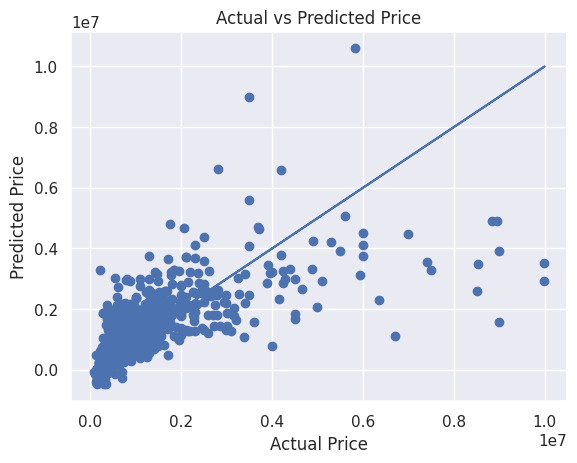

In [ ]:
# Linear Regression WITHOUT CV


model = LinearRegression()

# Fit model on training data
model.fit(X_train, y_train)

# predict on training
y_train_pred = model.predict(X_train)

# predict on testing
y_test_pred = model.predict(X_test)

# RMSE train
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# RMSE test
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Train RMSE:", round(train_rmse,2))
print("Test RMSE:", round(test_rmse,2))

#plot
plt.scatter(y_test, y_test_pred)
plt.plot(y_test, y_test)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show();

## Linear Regression with Nested Cross Validation

Cross-validation RMSE scores: [1008963.34 1058159.43  999035.51 1020335.97  970081.  ]
Mean RMSE: 1011315.05


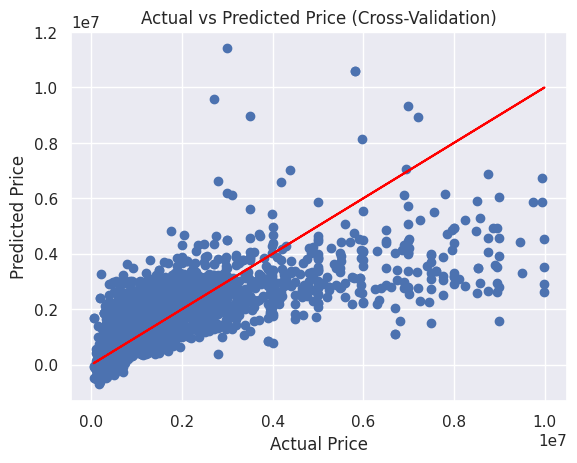

In [ ]:
# Linear Regression WITH CV

# 5 folds
num_folds = 5

#  for k-fold CV
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# compute cross val score
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

cv_rmse_scores = np.sqrt(-cv_scores)
cv_rmse_scores = np.round(cv_rmse_scores, decimals=2)

print("Cross-validation RMSE scores:", cv_rmse_scores)
print("Mean RMSE:", round((np.mean(cv_rmse_scores)),2))

# plot
plt.scatter(y, model.predict(X))
plt.plot(y, y, color='red')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price (Cross-Validation)')
plt.show()

## **Refelction for Linear Regression model**

We can see that the model does not do as well as we would hope. The RMSE is still in the millions. Compared to our baseline is it doing better, but still does not predict an accurate result.

## Ridge with no CV

In [ ]:
# Ridge with no CV
num_alphas = 30
alphas = np.logspace(-7, 7, num_alphas)

# Creating lists to store Alphas and MSEs
alpha = []
mse_train = []
mse_test = []
mse = []

# iterating over Alphas
for i, current_lambda in enumerate(alphas):
    # Initialize a Ridge Regression pipeline
    Ridge1 = make_pipeline(StandardScaler(), Ridge(alpha=current_lambda))

    # Fit the model with training data
    Ridge1.fit(X_train, y_train)

    # Predict on Training and Test data
    prediction_for_train = Ridge1.predict(X_train)
    prediction_for_test = Ridge1.predict(X_test)

    # Convert predictions to original scale before calculating MSE
    y_pred_train = prediction_for_train
    y_pred_test = (prediction_for_test)

    # Calculate MSE for each alpha and append to the list
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error((y_test), y_pred_test)
    mse.append((mse_train, mse_test))

# Calculate the training and testing RMSE
print("Training RMSE:", round((np.sqrt(mse_train)) ,2) )
print("Test RMSE:", round((np.sqrt(mse_test)) ,2) )

Training RMSE: 1488897.48
Test RMSE: 1324688.81


##Ridge with CV

Train RMSE: 992495.2
Test RMSE: 1003359.69


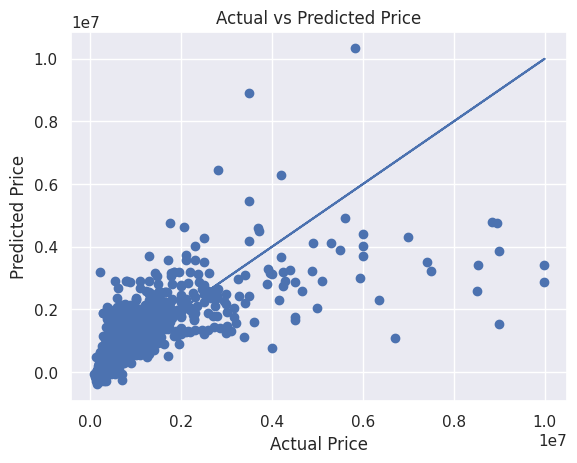

In [ ]:
# Ridge Regression
num_alphas = 30
alphas = np.logspace(-7, 7, num_alphas)

#Creating Lists to store Alphas and MSEs
alpha = []
mse_train = []
mse_test = []

# Initialize a Ridge Cross Validation Pipeline
model = make_pipeline(StandardScaler(), RidgeCV(alphas))

# Fit the model to the data
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate MSE for training and testing sets
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# RMSE values:
print("Train RMSE:", round((np.sqrt(mse_train)),2))
print("Test RMSE:", round((np.sqrt(mse_test)),2))

plt.scatter(y_test, y_test_pred)
plt.plot(y_test, y_test)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()

## **Reflection for Ridge Regression**

Since our RMSE for the test set are still in the millions, we do not see much improvement compared to the baseline, so we will continue training various models.

## KNN without CV

In [ ]:
# KNN WITHOUT CV

knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Predictions for both training and testing sets
train_pred = knn.predict(X_train)
test_pred = knn.predict(X_test)

# Calculate RMSE for both training and testing sets
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

# Print RMSE for both training and testing sets
print("Train RMSE:", round(train_rmse,2))
print("Test RMSE:", round(test_rmse,2))

Train RMSE: 941294.44
Test RMSE: 1119564.99


## KNN with CV


In [ ]:
# KNN WITH CV

knn = KNeighborsRegressor(n_neighbors = 5)
scores = cross_val_score(knn, X_train, y_train, scoring='neg_mean_squared_error', cv=7)
mse_scores = (-scores)
print("RMSE:", round((min(np.sqrt((mse_scores)))),2))

RMSE: 932622.6


## **Reflection for kNN**

We see slight improvement. We are now in the hundred-thousands. However, it is still pretty high.

## Lasso with no CV

In [ ]:
# Lasso with no CV
num_alphas = 30
alphas = np.logspace(-7, 7, num_alphas)

# Creating lists for alphas and MSEs
alpha = []
mse_train = []
mse_test = []
mse = []

# Iterating over Alphas
for i, current_lambda in enumerate(alphas):
    # Initialize a Lasso pipeline
    lass = make_pipeline(StandardScaler(), Lasso(alpha=current_lambda))

    # Fit the model with the training data
    lass.fit(X_train, y_train)

    # Make predictions on training and testing data
    prediction_for_train = lass.predict(X_train)
    prediction_for_test = lass.predict(X_test)

    # Convert predictions to original scale before calculating MSE
    y_pred_train = prediction_for_train
    y_pred_test = (prediction_for_test)

    # Calculate MSE for each alpha and append to the list
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error((y_test), y_pred_test)
    mse.append((mse_train, mse_test))

# Calculate the training and testing RMSE
print("Training RMSE:", round((np.sqrt(mse_train)),2))
print("Test RMSE:", round((np.sqrt(mse_test)),2))

Training RMSE: 1489355.6
Test RMSE: 1325106.69


## Lasso with CV


Train RMSE: 990798.3
Test RMSE: 1008108.73


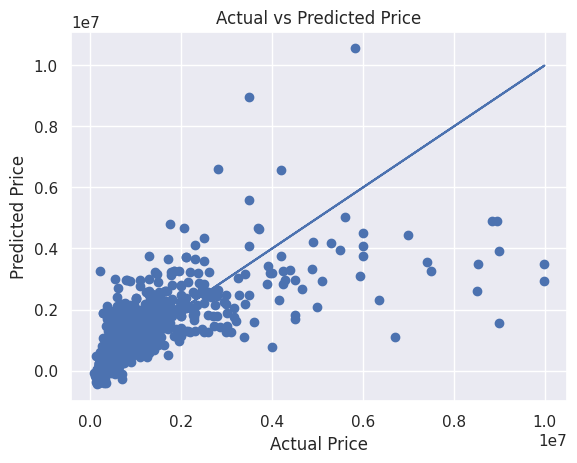

In [ ]:
# lasso
num_alphas = 30
alphas = np.logspace(-5,5, num_alphas)

# Create lists for Alphas and MSEs
alpha = []
mse=[]

# Initialize a Lasso Cross Validation pipleine
model = make_pipeline(StandardScaler(),LassoCV(alphas=alphas))

# Fit the model to the data
model.fit(X_train, y_train)

# Predict on the testing and training sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Get the MSEs and append them to the list
mse_train = mean_squared_error((y_train), y_train_pred)
mse_test = mean_squared_error((y_test), y_test_pred)
mse.append((mse_train, mse_test))

print("Train RMSE:", round((np.sqrt(mse_train)),2))
print("Test RMSE:", round((np.sqrt(mse_test)),2))

plt.scatter(y_test, y_test_pred)
plt.plot(y_test, y_test)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()

## **Reflection for Lasso**

Similar to Ridge, we do not see substantial improvement from the base model RMSE.

## Decision Tree Classification without CV

In [ ]:
# Decision Tree Classification

# Initialize a set of predictors
X = df[predictors]
y = df['Price_Percentile']

# redefine the splits and standardize
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create classifier
dt_classifier = DecisionTreeClassifier(max_depth=4, min_samples_split=35, random_state=42)

# fit
dt_classifier.fit(X_train, y_train)

# predict on training set
y_train_pred_intervals = dt_classifier.predict(X_train)

# predict on testing set
y_test_pred_intervals = dt_classifier.predict(X_test)

# find accuracy
train_acc = accuracy_score(y_train, y_train_pred_intervals)
test_acc = accuracy_score(y_test, y_test_pred_intervals)

print("Training Accuracy:", round(train_acc, 2))
print("Testing Accuracy:", round(test_acc, 2))


Training Accuracy: 0.35
Testing Accuracy: 0.3


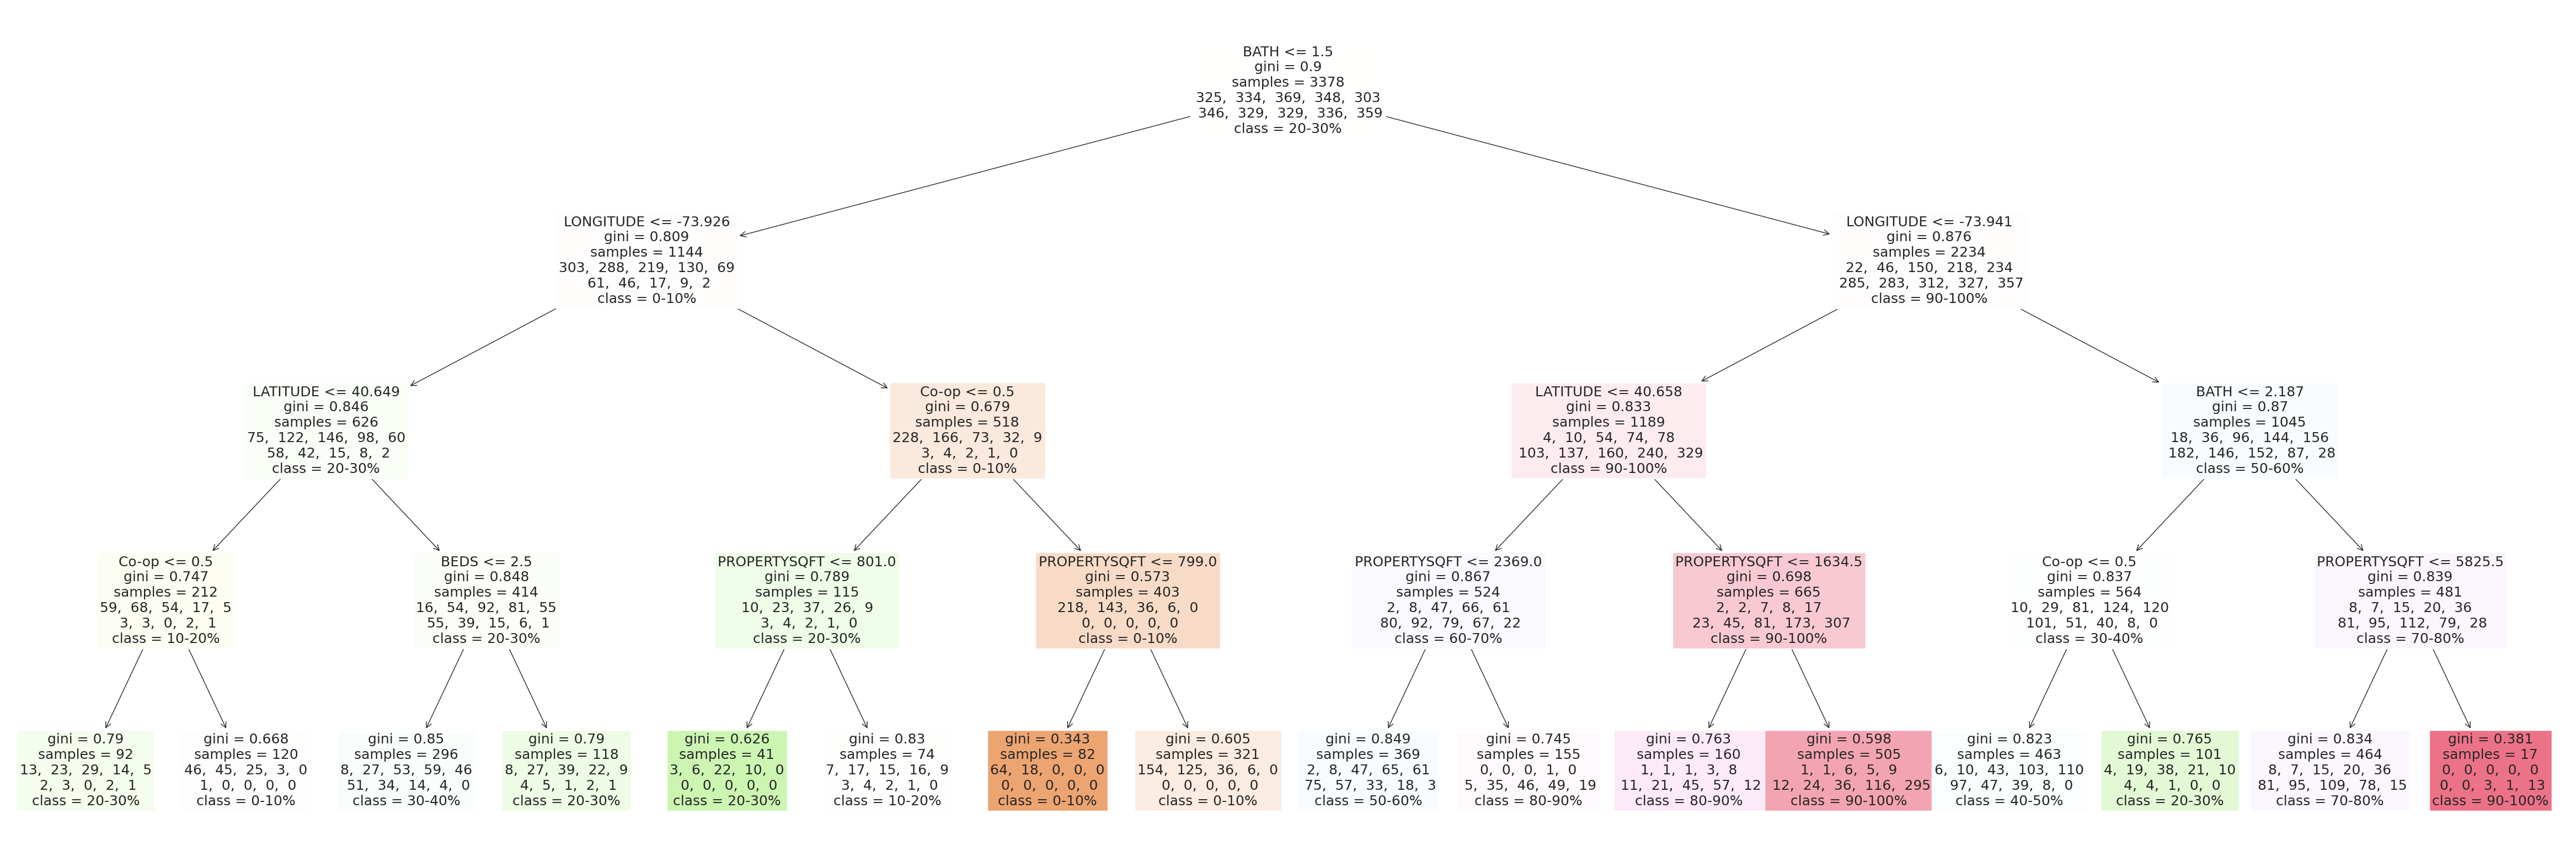

In [ ]:
# Plot the decision tree
plt.figure(figsize=(60, 20))


plot_tree(dt_classifier, feature_names=X.columns, fontsize=8, precision=2, class_names=dt_classifier.classes_, filled=True,rounded=True,)

def custom_plot_tree(dt, **kwargs):
    ax = plt.gca()
    result = plot_tree(dt, ax=ax, **kwargs)

# Format the value of each node to be displayed in two lines
    for node in result:
        if isinstance(node, plt.Annotation) and 'value' in node.get_text():
            values = node.get_text().replace('value = ', '').replace('[', '').replace(']', '').split(',')
            formatted_text = '\n'.join([', '.join(values[:5]), ', '.join(values[5:])])
            node.set_text(formatted_text)



custom_plot_tree(dt_classifier, feature_names=X.columns, class_names=dt_classifier.classes_, filled=True, fontsize=18)
plt.show()

## Decision Tree Classification with CV

In [ ]:
# perform CV on DT Classifciation

dt_classifier = DecisionTreeClassifier(max_depth=4, min_samples_split=35, random_state=42)

# 5-fold CV using cross_val_score
cv_scores = cross_val_score(dt_classifier, X, y, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Calculate the mean accuracy across all folds
mean_cv_accuracy = np.mean(cv_scores)
print("Mean Cross-Validation Accuracy:", round(mean_cv_accuracy, 2))

Cross-Validation Scores: [0.26863905 0.32662722 0.33964497 0.34004739 0.29976303]
Mean Cross-Validation Accuracy: 0.31


## Regression Decision Tree without CV

In [ ]:
# Resetting split from classification
predictors = [col for col in df.columns if col not in cols]

# # Separate the features (X) and target variable (y)
X = df[predictors]
y = df['PRICE']

# retrain after the classifier and standardize

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [ ]:
# Decision Tree with no CV

# Create the Decision Tree model
dt = DecisionTreeRegressor(max_depth=5,min_samples_split=35)

# Fit the Decision Tree Regressor on the training data
dt.fit(X_train, y_train)

# Predictions on training data
y_train_pred = dt.predict(X_train)

# Predictions on testing data
y_test_pred = dt.predict(X_test)

# Calculate RMSE for training and testing data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Training RMSE:", round(train_rmse,2))
print("Testing RMSE:", round(test_rmse,2))


Training RMSE: 790633.33
Testing RMSE: 799751.97


## Regression Decision Tree with CV

In [ ]:
# Decision tree with CV

depths= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
# ctr=1

# Creating lists for MSEs and depths
mses = []
depthscurrent = []

# try different alphas to see the effect on tree size
for max_depth in depths:
  # Creating the Decision Tree Model
  dt = DecisionTreeRegressor(max_depth=max_depth)
  crossvals = cross_val_score(dt, X_train, y_train, scoring = "neg_mean_squared_error", cv = 15, n_jobs =-1)
  depthscurrent.append(np.mean(-crossvals))
  #print(max_depth, depthscurrent[-1])

# Get the best MSE and the index
bestmse = min(depthscurrent)
bestmse_index = np.where(depthscurrent == bestmse)

bestmse_indexnumber = bestmse_index[0][0]
#print(bestmse_indexnumber)

# Get the depth of the best MSE
depthofbestmse = depths[bestmse_indexnumber]

print("RMSE:", round((np.sqrt(bestmse)),2))
print( "Depth of Tree:",depthofbestmse)

RMSE: 857852.65
Depth of Tree: 6


## Decision Tree with GridSearch CV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Setting the parameters
param_grid = {
    'max_depth': [None, 2, 5, 6, 7, 10, 15, 20],
}
# Creating a Decision Tree instance
dt = DecisionTreeRegressor()

# Grid Search with Cross Validation
grid_search = GridSearchCV(dt, param_grid, scoring='neg_mean_squared_error', cv=300, n_jobs=-1)

# Fitting the grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Getting the best model from Grid Search
best_rf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE Score:", round((np.sqrt(-grid_search.best_score_)),2) )

Best Parameters: {'max_depth': 6}
Best RMSE Score: 841624.63


## Decision Tree with Nested CV

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# Setting up inner and outer cross validation
inner_cv = KFold(n_splits=4, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)

# Setting the parameters
param_grid = {
    'max_depth': [None, 2, 5, 6, 7, 10, 15, 20],
}

# Creating the Decision Tree instance
dt = DecisionTreeRegressor()

# Grid serach with Outer Cross Validation
grid_search = GridSearchCV(dt, param_grid, scoring='neg_mean_squared_error', cv=outer_cv, n_jobs=-1)

# Fitting the Grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Nested CV with parameter optimization
nested_scores = cross_val_score(grid_search, X=X_train, y=y_train, cv=outer_cv, scoring='neg_mean_squared_error')
nested_rmse_scores = np.sqrt(-nested_scores)
nested_rmse_mean = nested_rmse_scores.mean()
print("RMSE:",round(nested_rmse_mean,2))

RMSE: 883463.58


## **Reflection for Decision Tree**

We see a substantial improvement from the baseline model when training a decision tree. We are now in the 800-thousands, which is a big jump from the baseline model. We see that gride search Cross Validation does the best in this case. We tried regular CV, grid search CV, and nested CV to perform parameter tuning so we can achieve the best model.

## Bagging

Train RMSE: 1278099.33
Test RMSE: 1154752.71


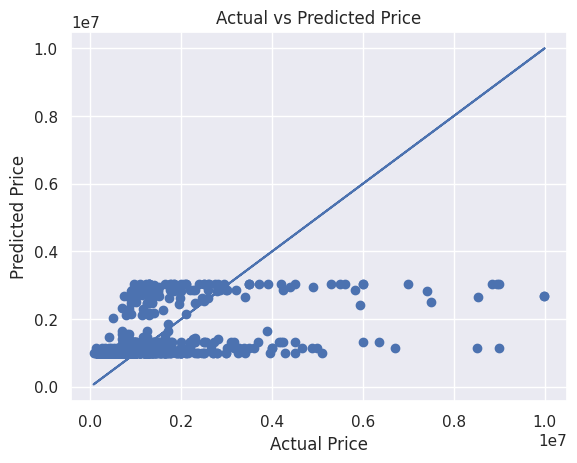

In [ ]:
# BAGGING WITHOUT CV

# Creating the Decision Tree instance
dt = DecisionTreeRegressor(max_depth=1)

# Creating a Bagging Regressor
bag = BaggingRegressor(estimator = dt, n_estimators=100)

# Fitting the model to the data
bag.fit(X_train, y_train)

# Predicting on the training and testing data
yhat_train = bag.predict(X_train)
yhat_test = bag.predict(X_test[predictors])

# Calculate RMSE for training data
train_mse = mean_squared_error(y_train, yhat_train)
train_rmse = np.sqrt(train_mse)
print("Train RMSE:", round(train_rmse,2))

# Calculate RMSE for test data
test_mse = mean_squared_error(y_test, yhat_test)
test_rmse = np.sqrt(test_mse)
print("Test RMSE:", round(test_rmse,2))

# Plot
plt.scatter(y_test, yhat_test)
plt.plot(y_test, y_test)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()

## **Bagging with CV**

Training RMSE: 1034388.71
Testing RMSE: 1155637.75


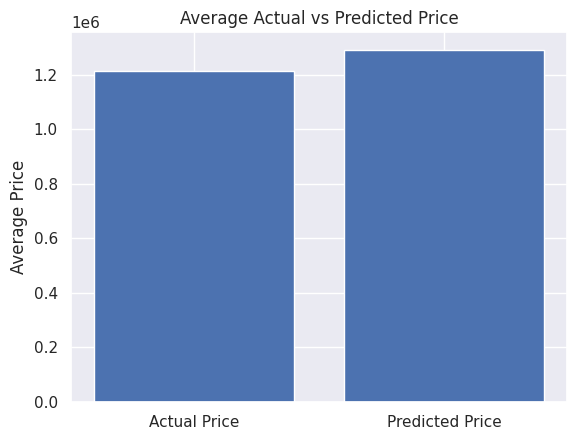

In [ ]:
# Bagging WITH CV

# Creating a Decision Tree instance
dt = DecisionTreeRegressor(max_depth=1)

# Creating a Bagging Regressor
bag = BaggingRegressor(base_estimator=dt, n_estimators=100)

# perform cross validation using cross_val_score
train_scores = cross_val_score(bag, X_train, y_train, cv=15, scoring='neg_mean_squared_error')
train_rmse_scores = np.sqrt(-train_scores)
print("Training RMSE:", round((min(train_rmse_scores)),2))

# fit the model to the training instances
bag.fit(X_train, y_train)

# Predict on the test set
yhat_test = bag.predict(X_test)

# Calculating the MSE
test_mse = mean_squared_error(y_test, yhat_test)
test_rmse = np.sqrt(test_mse)
print("Testing RMSE:", round(test_rmse,2))
#plot the different between the actual price and the predicted
avgprice = np.mean(y_test)
avgpred = np.mean(yhat_test)
plt.bar(['Actual Price', 'Predicted Price'], [avgprice, avgpred])
plt.ylabel('Average Price')
plt.title('Average Actual vs Predicted Price')
plt.show()

## **Bagging with GridSearchCV**

In [ ]:
# Bagging with Grid Search Cross Validation
from sklearn.model_selection import GridSearchCV

# Defining the parameters
param_grid_2 = {
    'n_estimators': [50, 100, 200],
    'base_estimator__max_depth': [None, 5, 10]
}

param_grid = {
    'max_depth': [None, 2, 5, 6, 10, 15, 20],
}

# Creating a Decision Tree instance
dt = DecisionTreeRegressor()

# Performing Grid Search for Decision Tree with Cross Validation
grid_search_dt = GridSearchCV(dt, param_grid, scoring='neg_mean_squared_error', cv=25, n_jobs=-1)

# Fitting the model to the Data
grid_search_dt.fit(X_train, y_train)

# Creating a Bagging Regressor model
bagging_model = BaggingRegressor(base_estimator=grid_search_dt.best_estimator_, random_state=42)

# Performing Grid search for bagging with CrossValidation
grid_search = GridSearchCV(estimator=bagging_model, param_grid=param_grid_2, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

# Getting the best parameters, estimators, and best RMSE score from the grid search
best = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_score = np.sqrt(-grid_search.best_score_)


print("Best Parameters:", best)
print("Best RMSE:", round(best_score,2))

Best Parameters: {'base_estimator__max_depth': None, 'n_estimators': 50}
Best RMSE: 730500.49


## **Bagging with Nested CV**

In [ ]:
#Bagging with Nested Cross Validation

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# Setting the inner and outer CV parameters
inner_cv = KFold(n_splits=4, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)

# Defining the paramter grid for the decision tree
param_grid_2 = {
    'n_estimators': [50, 100, 200],
    'base_estimator__max_depth': [None, 5, 10]
}

param_grid = {
    'max_depth': [None, 2, 5, 6, 10, 15, 20],
}

# Creating a Decision Tree instance
dt = DecisionTreeRegressor()

# Performing Grid Search for Decision Tree with Cross Validation
grid_search_dt = GridSearchCV(dt, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Creating a bagging regressor with the decision tree estimator
bagging_model = BaggingRegressor(grid_search_dt.best_estimator_, random_state=42)

# Performing the grid search for bagging with the Cross Validation
grid_search_bagging = GridSearchCV(estimator=bagging_model, param_grid=param_grid_2, scoring='neg_mean_squared_error', cv=inner_cv)
grid_search_bagging.fit(X_train, y_train)

# Performing the nested Cross validation and getting the scores
nested_scores = cross_val_score(grid_search_bagging, X=X_train, y=y_train, cv=outer_cv, scoring='neg_mean_squared_error')
nested_rmse_scores = np.sqrt(-nested_scores)
nested_rmse_mean = nested_rmse_scores.mean()
print("Nested CV Average RMSE:", round(nested_rmse_mean,2))

Nested CV Average RMSE: 717926.63


In [ ]:
# from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# inner_cv = KFold(n_splits=4, shuffle=True, random_state=42)
# outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)

# param_grid_2 = {
#     'n_estimators': [50, 100, 200],
#     'base_estimator__max_depth': [None, 5, 10]
# }

# param_grid = {
#     'max_depth': [None, 2, 5, 6, 10, 15, 20],
# }
# dt = DecisionTreeRegressor()
# grid_search_dt = GridSearchCV(dt, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
# grid_search_dt.fit(X_train, y_train)

# bagging_model = BaggingRegressor(grid_search_dt.best_estimator_, random_state=42)
# grid_search_bagging = GridSearchCV(estimator=bagging_model, param_grid=param_grid_2, scoring='neg_mean_squared_error', cv=inner_cv)
# grid_search_bagging.fit(X_train, y_train)

# nested_scores = cross_val_score(grid_search_bagging, X=X_train, y=y_train, cv=outer_cv, scoring='neg_mean_squared_error')
# nested_rmse_scores = np.sqrt(-nested_scores)
# nested_rmse_mean = nested_rmse_scores.mean()
# print("Nested CV Average RMSE:", round(nested_rmse_mean,2))

In [ ]:
# from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# inner_cv = KFold(n_splits=4, shuffle=True, random_state=42)
# outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)

# param_grid_2 = {
#     'n_estimators': [50, 100, 200],
#     'base_estimator__max_depth': [None, 5, 10]
# }

# param_grid = {
#     'max_depth': [None, 2, 5, 6, 10, 15, 20],
# }
# dt = DecisionTreeRegressor()
# grid_search_dt = GridSearchCV(dt, param_grid, scoring='neg_mean_squared_error', cv=7, n_jobs=-1)
# grid_search_dt.fit(X_train, y_train)

# bagging_model = BaggingRegressor(grid_search_dt.best_estimator_, random_state=42)
# grid_search_bagging = GridSearchCV(estimator=bagging_model, param_grid=param_grid_2, scoring='neg_mean_squared_error', cv=inner_cv)
# grid_search_bagging.fit(X_train, y_train)

# nested_scores = cross_val_score(grid_search_bagging, X=X_train, y=y_train, cv=outer_cv, scoring='neg_mean_squared_error')
# nested_rmse_scores = np.sqrt(-nested_scores)
# nested_rmse_mean = nested_rmse_scores.mean()
# print("Nested CV Average RMSE:", round(nested_rmse_mean,2))

## **Reflection for Bagging**

We see a dramatic increase in prediction accuracy here. Our RMSE got to as low as 720,000. This is substantially better than the baseline model. We see that the nested CV is performing the best for this model and performed the proper parameter tuning.

## **Boosting Model without CV**

Training RMSE: 1118131.27
Testing RMSE: 1015605.51


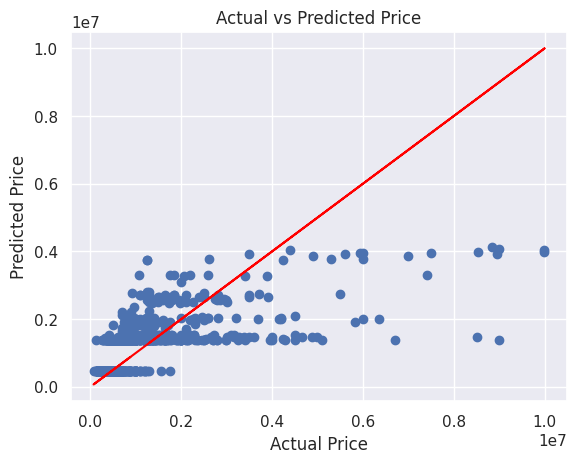

In [ ]:
# Boosting WITHOUT CV

boost = AdaBoostRegressor(n_estimators=50, base_estimator=DecisionTreeRegressor(max_depth=2), learning_rate=0.01)

# Fit the AdaBoostRegressor on the training data
boost.fit(X_train, y_train)

# Predictions on training data
yhat_train_boost = boost.predict(X_train)

# Predictions on testing data
yhat_test_boost = boost.predict(X_test)

# Calculate RMSE for training and testing data
train_rmse = np.sqrt(mean_squared_error(y_train, yhat_train_boost))
test_rmse = np.sqrt(mean_squared_error(y_test, yhat_test_boost))

print("Training RMSE:", round(train_rmse,2))
print("Testing RMSE:", round(test_rmse,2))

# Plot
plt.scatter(y_test, yhat_test_boost)
plt.plot(y_test, y_test, color='red')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()

## **Boosting Model with CV**

In [ ]:
# Boosting WITH CV

vals = []
boosting_model = AdaBoostRegressor(n_estimators=50, base_estimator=DecisionTreeRegressor(max_depth=5), learning_rate=0.01)
scores = cross_val_score(boosting_model, X_train, y_train, cv=15, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print("CV Average RMSE:" , round(np.mean(rmse_scores),2) )

# Plot

#plt.scatter(y_test, rmse_scores)
#plt.plot(y, y, color='red')
#plt.xlabel('Actual Price')
#plt.ylabel('Predicted Price')
#plt.title('Actual vs Predicted Price (Cross-Validation)')
#plt.show()

CV Average RMSE: 788198.92


## **Boosting Model with GridSeacrh CV**

Best Parameters: {'base_estimator__max_depth': None, 'n_estimators': 50}
Best RMSE: 757989.89


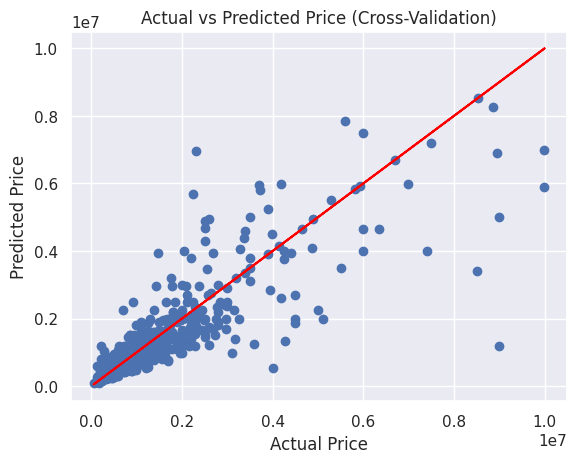

In [ ]:
# grid search for Boosting

from sklearn.model_selection import GridSearchCV

# Defining the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'base_estimator__max_depth': [None, 5, 10]
}

# Creating an Ada Boost Regressor instance
boost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=42, learning_rate=0.01)

# Performing grid search
grid_search = GridSearchCV(estimator=boost, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

# Getting the best parameters, estimator and RMSE
best = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_score = np.sqrt(-grid_search.best_score_)

print("Best Parameters:", best)
print("Best RMSE:", round(best_score,2))
plt.scatter(y_test, grid_search.predict(X_test))
plt.plot(y, y, color='red')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price (Cross-Validation)')
plt.show()

## **Boosting Model with Nested CV**

Nested CV Average RMSE: 728596.67


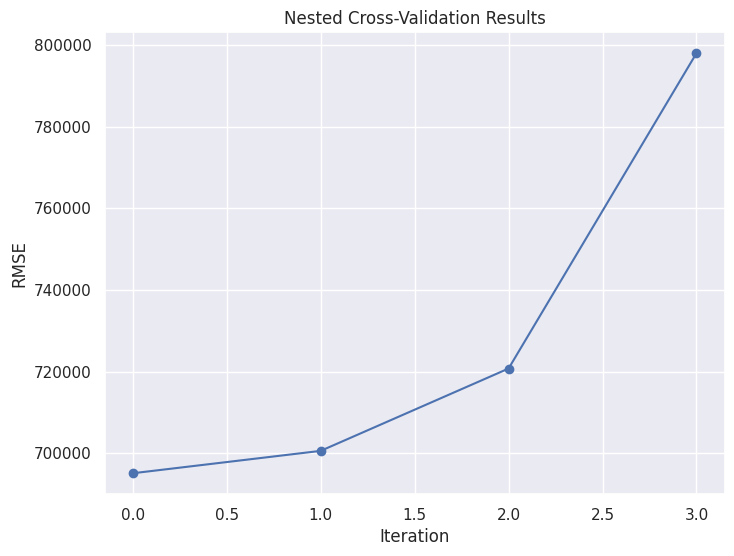

In [ ]:
# Boosting mode from Nested Cross Validation
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# Defining the inner and outer Cross Validation Strategies
inner_cv = KFold(n_splits=4, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)

# Defining the parameter Grid
param_grid_2 = {
    'n_estimators': [50, 100, 200],
    'base_estimator__max_depth': [None, 5, 10]
}

param_grid = {
    'max_depth': [None, 2, 5, 6, 10, 15, 20],
}

# Creating a Decision Tree instance
dt = DecisionTreeRegressor()

# Performing grid search
grid_search_dt = GridSearchCV(dt, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Creating a Boosting mode instance
boosting_model = AdaBoostRegressor(grid_search_dt.best_estimator_, random_state=42, learning_rate=0.01)

# Performing grid search on Boosted model
grid_search_boosting = GridSearchCV(estimator=boosting_model, param_grid=param_grid_2, scoring='neg_mean_squared_error', cv=inner_cv)
grid_search_boosting.fit(X_train, y_train)

# Performing Nested Cross Validation to evaluate the model
nested_scores = cross_val_score(grid_search_boosting, X=X_train, y=y_train, cv=outer_cv, scoring='neg_mean_squared_error')
nested_rmse_scores = np.sqrt(-nested_scores)
nested_rmse_mean = nested_rmse_scores.mean()
print("Nested CV Average RMSE:", round(nested_rmse_mean,2))

plt.figure(figsize=(8, 6))
plt.plot(range(len(nested_rmse_scores)), nested_rmse_scores, marker='o', linestyle='-')
plt.title('Nested Cross-Validation Results')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()



In [ ]:
# from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# inner_cv = KFold(n_splits=4, shuffle=True, random_state=42)
# outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)

# param_grid_2 = {
#     'n_estimators': [50, 100, 200],
#     'base_estimator__max_depth': [None, 5, 10]
# }

# param_grid = {
#     'max_depth': [None, 2, 5, 6, 10, 15, 20],
# }
# dt = DecisionTreeRegressor()
# grid_search_dt = GridSearchCV(dt, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
# grid_search_dt.fit(X_train, y_train)

# boosting_model = AdaBoostRegressor(grid_search_dt.best_estimator_, random_state=42, learning_rate=0.01)
# grid_search_boosting = GridSearchCV(estimator=boosting_model, param_grid=param_grid_2, scoring='neg_mean_squared_error', cv=inner_cv)
# grid_search_boosting.fit(X_train, y_train)

# nested_scores = cross_val_score(grid_search_boosting, X=X_train, y=y_train, cv=outer_cv, scoring='neg_mean_squared_error')
# nested_rmse_scores = np.sqrt(-nested_scores)
# nested_rmse_mean = nested_rmse_scores.mean()
# print("Nested CV Average RMSE:", round(nested_rmse_mean,2))

In [ ]:
# from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# inner_cv = KFold(n_splits=4, shuffle=True, random_state=42)
# outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)

# param_grid_2 = {
#     'n_estimators': [50, 100, 200],
#     'base_estimator__max_depth': [None, 5, 10]
# }

# param_grid = {
#     'max_depth': [None, 2, 5, 6, 10, 15, 20],
# }
# dt = DecisionTreeRegressor()
# grid_search_dt = GridSearchCV(dt, param_grid, scoring='neg_mean_squared_error', cv=7, n_jobs=-1)
# grid_search_dt.fit(X_train, y_train)

# boosting_model = AdaBoostRegressor(grid_search_dt.best_estimator_, random_state=42, learning_rate=0.01)
# grid_search_boosting = GridSearchCV(estimator=boosting_model, param_grid=param_grid_2, scoring='neg_mean_squared_error', cv=inner_cv)
# grid_search_boosting.fit(X_train, y_train)

# nested_scores = cross_val_score(grid_search_boosting, X=X_train, y=y_train, cv=outer_cv, scoring='neg_mean_squared_error')
# nested_rmse_scores = np.sqrt(-nested_scores)
# nested_rmse_mean = nested_rmse_scores.mean()
# print("Nested CV Average RMSE:", round(nested_rmse_mean,2))

## **Reflection for Boosting**

Here we see our best model yet. We get an RMSE in the 500,000's. This is a substantial decrease from our baseline model (well over a 50% decrease). Thus, we can conclude that so far, our boosting model with CV is doing the best. We perform regular CV, GridSearch CV, and nested CV to properly tune our parameters to ensure we are getting the lowest possible result.

## Random Forest without CV


In [ ]:
# Random Forest

rf = RandomForestRegressor(n_estimators=20,
                            random_state=42,
                            min_samples_split=10,  # Adjust this parameter
                            min_samples_leaf=10)   # Adjust this parameter
                            #min_impurity_decrease=)  # Adjust this parameter

# Fit the Random Forest Regressor on the training data
rf.fit(X_train, y_train)

# Predictions on training data
y_train_pred = rf.predict(X_train)

# Predictions on testing data
y_test_pred = rf.predict(X_test)

# Calculate RMSE for training and testing data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Training RMSE:", round(train_rmse,2))
print("Testing RMSE:", round(test_rmse,2))

# Calculating R^2 values

train_r2 = r2_score(y_train, y_train_pred)

# Calculate R^2 score for testing data
test_r2 = r2_score(y_test, y_test_pred)

print("Training R^2 score:", round(train_r2, 2))
print("Testing R^2 score:", round(test_r2, 2))

Training RMSE: 618735.38
Testing RMSE: 700271.14
Training R^2 score: 0.83
Testing R^2 score: 0.72


## **Random Forest with CV**

In [ ]:
# Random Forest WITH CV

rf = RandomForestRegressor(n_estimators=20,
                            random_state=42,
                            min_samples_split=10,
                            min_samples_leaf=10)


train_scores = cross_val_score(rf, X_train, y_train, scoring='neg_mean_squared_error', cv=2000)
test_rmse_scores = np.sqrt(-train_scores)
print("Cross validation Average RMSE:", round((np.mean(test_rmse_scores)),2))



Cross validation Average RMSE: 423877.99


Cross validation Average RMSE: 665721.77


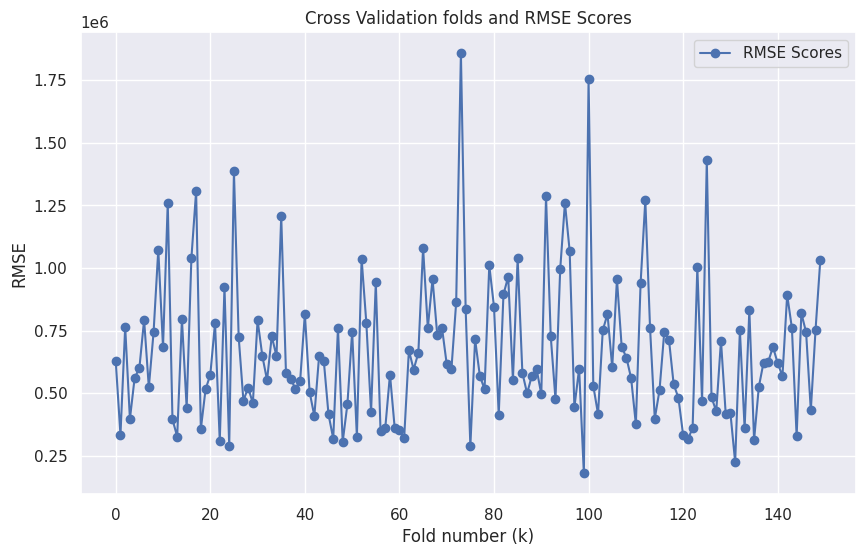

In [ ]:
# Random Forest WITH CV

rf = RandomForestRegressor(n_estimators=20,
                            random_state=42,
                            min_samples_split=10,  # Adjust this parameter
                            min_samples_leaf=10)   # Adjust this parameter
                            #min_impurity_decrease=)  # Adjust this parameter

train_scores = cross_val_score(rf, X_train, y_train, scoring='neg_mean_squared_error', cv=150)
test_rmse_scores = np.sqrt(-train_scores)
print("Cross validation Average RMSE:", round((np.mean(test_rmse_scores)),2))

plt.figure(figsize=(10, 6))
plt.plot(range(len(test_rmse_scores)), test_rmse_scores, marker='o', color='b', label='RMSE Scores')
plt.xlabel('Fold number (k)')
plt.ylabel('RMSE')
plt.title('Cross Validation folds and RMSE Scores')
plt.legend()
plt.show()


## **Note**
Although we see a dramatic decrease in MSE, we are trading computational cost and variance. Thus, we take these numbers with a grain of salt

## **Random Forest with GridSearch CV**

In [ ]:
# Random forest grid search CV


# Setting up the parameter grid
param_grid = {
    'n_estimators': [5, 10, 20, 50, 100],
    # 'min_samples_split': [2, 4, 10, 15, 20, 25, 30, 35, 40, 45],
    # 'min_samples_leaf': [1,2,3,4 , 10, 20, 25, 30, 35, 40, 45]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid,cv=100,  scoring='neg_mean_absolute_error',  n_jobs=-1)


# fit the grid search
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# find the best estimators
best_rf = grid_search.best_estimator_

# predict with the best estimator
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# find the RMSEs
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Training RMSE:", round(train_rmse,2))
print("Testing RMSE:", round(test_rmse,2))

Best Parameters: {'n_estimators': 100}
Training RMSE: 263579.3
Testing RMSE: 656997.93


In [ ]:
# Calulating the R^2 scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Getting the RMSEs
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Training R^2:", round(train_r2, 2))
print("Testing R^2:", round(test_r2, 2))
print("Training RMSE:", round(train_rmse, 2))
print("Testing RMSE:", round(test_rmse, 2))


Training R^2: 0.83
Testing R^2: 0.72
Training RMSE: 618735.38
Testing RMSE: 700271.14


## **Random Forest with Nested CV**

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# Setting the inner and outer paramters
inner_cv = KFold(n_splits=4, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)

# Setting the parameter grid
param_grid = {
    'max_depth': [None, 5, 10, 20],
}

# Performing Grid search for random Forest with Cross Validation
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=inner_cv)
grid_search_rf.fit(X_train, y_train)

# Performing Nested Cross Validation to evaluate the model
nested_scores = cross_val_score(grid_search_rf, X=X_train, y=y_train, cv=outer_cv, scoring='neg_mean_squared_error')
nested_rmse_scores = np.sqrt(-nested_scores)
nested_rmse_mean = nested_rmse_scores.mean()
print("Nested CV average RMSE:", round(nested_rmse_mean,2))

Nested CV average RMSE: 752712.31


## **Reflection for Random Forest**

We see here that although Random Forest (even with all forms of cross-validation) does do better than the initial baseline, it does not do better than the boosted model. As a result, we know it is not our best model.

## **Neural Network**

In [ ]:
# Neural Network

#Scaling the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compiling the model with Adam optimizer and mean squared loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model on the training data
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Make predicions on the data
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Training RMSE:", round(train_rmse,2))
print("Test RMSE:", round(test_rmse,2))

Epoch 1/100
85/85 [==============================] - 2s 10ms/step - loss: 4019872071680.0000 - val_loss: 3459084713984.0000
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 4019592364032.0000 - val_loss: 3458552561664.0000
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 4018484019200.0000 - val_loss: 3456918880256.0000
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 4015737536512.0000 - val_loss: 3453501046784.0000
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 4010728488960.0000 - val_loss: 3447597563904.0000
Epoch 6/100
85/85 [==============================] - 0s 4ms/step - loss: 4002926559232.0000 - val_loss: 3439022309376.0000
Epoch 7/100
85/85 [==============================] - 0s 4ms/step - loss: 3991320920064.0000 - val_loss: 3426755280896.0000
Epoch 8/100
85/85 [==============================] - 0s 4ms/step - loss: 3975616659456.0000 - val_loss: 3410392776704.0000
Epoch 9/100
85/

## **Reflection for Neural Network**

We see that the Neural Network does not work as well on our data set because we are predicting something that is more linear. The model performs poorly in terms of our baseline


## **Final Reflection**


After running all of our models, we have determined that Random Forest is our most accurate model. We take this with a grain of salt because we are trading a dramatic decrease in bias for a pretty big increase in variance. We tried many models with many different hyperparameters. We concluded after different types of cross variance including grid search and nested cross validation that Random Forest has the smallest RMSE. Our baseline model, which predicts the average price for each column is significantly out-preformed by this model, and, as a result, we choose it as our model. Throughout the process, we saw that although some models may do better, we trade a significant computational cost or severely overfit.